In [17]:
import pandas as pd
import numpy as np
import os
import gc
import datetime as dt
import warnings

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 20
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 8]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 5))  
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.linear_model import LassoCV,Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from alibi.explainers import ALE, plot_ale, AnchorTabular

import warnings 
warnings.filterwarnings('ignore')

import alibi
import shap
from sklearn_gbmi import *

In [9]:
train = pd.read_csv('train_regressor.csv')
test = pd.read_csv('test_regressor.csv')
def binary_class(df):
    return(pd.qcut(df,2,labels=False))   
def multi_class(df):
    return(pd.qcut(df,10,labels=False))
    
train['binary_class'] = train.groupby(['datadate'])['forward_excess_ret'].transform(binary_class)
train.dropna(subset=['forward_excess_ret'],inplace=True)
train['multi_class'] = train.groupby(['datadate'])['forward_excess_ret'].transform(multi_class)
test['binary_class'] = test.groupby(['datadate'])['forward_excess_ret'].transform(binary_class)
test.dropna(subset=['forward_excess_ret'],inplace=True)
test['multi_class'] = test.groupby(['datadate'])['forward_excess_ret'].transform(multi_class)

feature_names=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']

In [11]:
X_train = train[feature_names]
y_train = train['forward_excess_ret']
X_test = train[feature_names]
y_test = train['forward_excess_ret']

In [13]:
linear = LinearRegression().fit(X_train,y_train)
lasso = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train) 
DT = DecisionTreeRegressor(max_depth=5,random_state=0).fit(X_train,y_train)
knn = KNeighborsRegressor(n_neighbors=20).fit(X_train,y_train)
rf = RandomForestRegressor(max_depth=5).fit(X_train,y_train)
ada = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
xg = XGBRegressor(max_depth=10).fit(X_train,y_train)
gb = GradientBoostingRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
mlp = MLPRegressor(solver='lbfgs', alpha=0.01,hidden_layer_sizes=(15,3), random_state=1).fit(X_train,y_train)

[12:56:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [18]:
def metrics(model):  
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train,y_train, cv=5)
    print('Train')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f '%mse(y_train, train_pred))
    print('-----------------------------------------')
    
    scores = cross_val_score(model, X_test,y_test, cv=5)
    print('Test')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f'%mse(y_test, test_pred))

## PDP

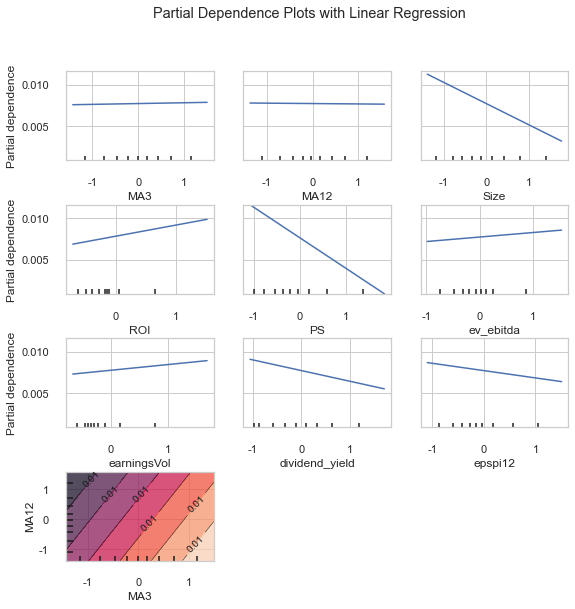

In [28]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt

features = list(range(len(feature_names)))
features.append((0,1))

plot_partial_dependence(linear, X_train, features, feature_names=feature_names) 
fig = plt.gcf()
fig.set_size_inches(9, 9) 

fig.suptitle('Partial Dependence Plots with Linear Regression')
fig.subplots_adjust(hspace=0.5)

In [30]:
###########XGBOOSTING################ 不能跑PDP
features = list(range(len(feature_names)))
features.append((0,1))

plot_partial_dependence(xg.fit(X_train,y_train), X_train, features, feature_names=feature_names) 
fig = plt.gcf()
fig.set_size_inches(9, 9) 
fig.suptitle('Partial Dependence Plots with rf')
fig.subplots_adjust(hspace=0.5)

[13:11:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NotFittedError: This XGBRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## ALE

In [ ]:
#### XGBoosting####### 跑不了

ALE for Linear Regression:


ValueError: feature_names mismatch: ['MA3', 'MA12', 'Size', 'ROI', 'PS', 'ev_ebitda', 'earningsVol', 'dividend_yield', 'epspi12'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
expected earningsVol, ROI, epspi12, PS, MA12, ev_ebitda, MA3, Size, dividend_yield in input data
training data did not have the following fields: f4, f3, f5, f8, f2, f0, f6, f7, f1

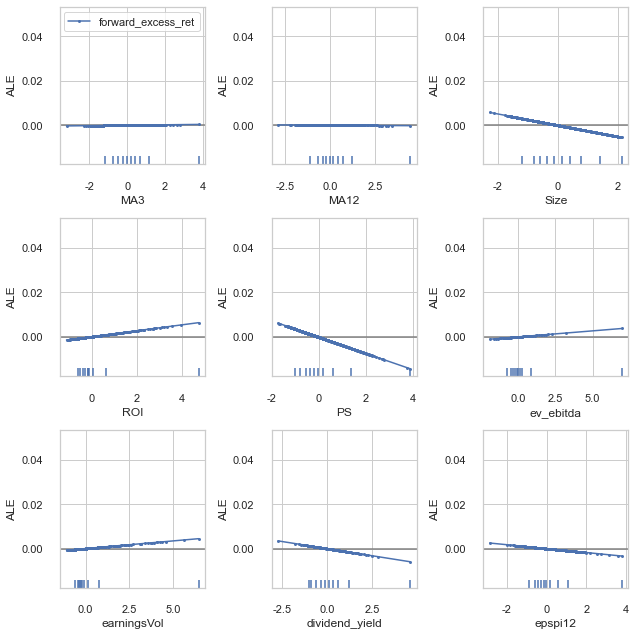

In [31]:
from alibi.explainers import ALE, plot_ale, AnchorTabular
ale_lr = ALE(linear.predict, feature_names=feature_names, target_names = ['forward_excess_ret'])
exp_lr = ale_lr.explain(X_train.values)
print('ALE for Linear Regression:')
plot_ale(exp_lr, fig_kw={'figwidth':9, 'figheight': 9})

ale_xg = ALE(xg.predict, feature_names=feature_names, target_names = ['forward_excess_ret'])
exp_xg = ale_xg.explain(X_train.values)
print('ALE for XGBoosting:')
plot_ale(exp_lr, fig_kw={'figwidth':9, 'figheight': 9})

## H stats

In [38]:
d = h_all_pairs(gb, X_train)
l=sorted(d.items(), key=lambda x: x[1])
l

[(('PS', 'earningsVol'), 0.02182257311313167),
 (('MA12', 'earningsVol'), 0.05324426319093985),
 (('PS', 'epspi12'), 0.06713317869401302),
 (('ev_ebitda', 'earningsVol'), 0.08303972114394118),
 (('Size', 'ev_ebitda'), 0.08982349763701537),
 (('Size', 'PS'), 0.09091699890810201),
 (('MA12', 'Size'), 0.09472210996959447),
 (('MA12', 'ev_ebitda'), 0.11804203982730457),
 (('Size', 'epspi12'), 0.12662221667941878),
 (('MA12', 'dividend_yield'), 0.13214032049742305),
 (('MA3', 'ev_ebitda'), 0.1420414494248073),
 (('earningsVol', 'epspi12'), 0.14338013861986879),
 (('MA3', 'PS'), 0.1471063615296332),
 (('MA12', 'epspi12'), 0.15244323285331107),
 (('ROI', 'earningsVol'), 0.15436916541836315),
 (('ROI', 'epspi12'), 0.15975639362506389),
 (('PS', 'ev_ebitda'), 0.161456144439382),
 (('ROI', 'PS'), 0.16698205791657558),
 (('MA3', 'dividend_yield'), 0.17484792308803018),
 (('MA3', 'MA12'), 0.1767978714914584),
 (('Size', 'dividend_yield'), 0.1827522808959131),
 (('MA12', 'PS'), 0.18406517596405145)

## SHAP

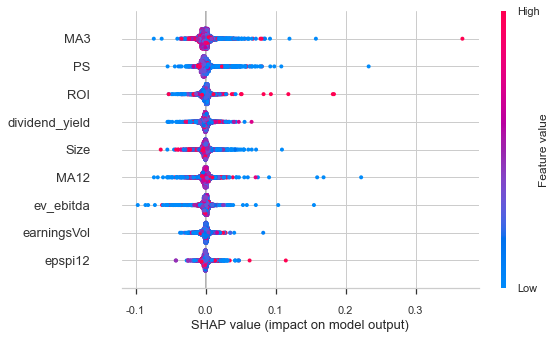

In [34]:
xg_shap = shap.TreeExplainer(xg)
xg_shap_values = xg_shap.shap_values(X_train)
xg_shap_interaction = xg_shap.shap_interaction_values(X_train)
shap.summary_plot(xg_shap_values, X_train)

In [35]:
shap.initjs()
def shap_plot(j):
    explainerModel = shap.TreeExplainer(xg)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)
shap_plot(0)

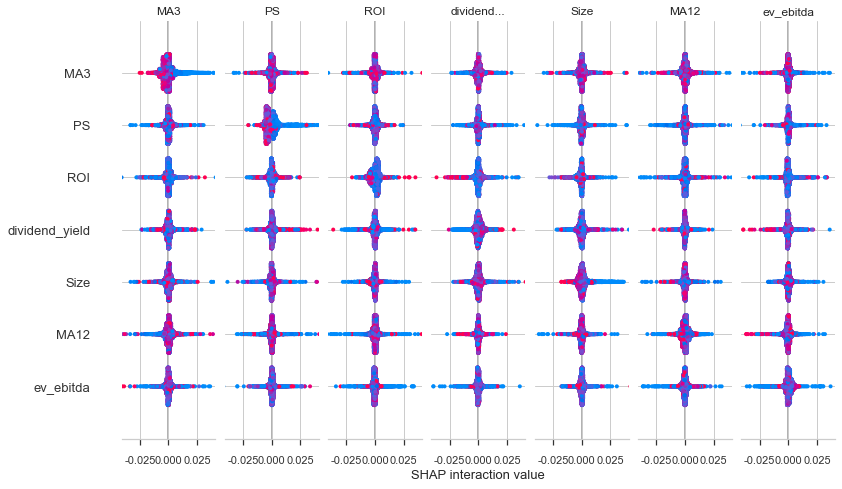

In [36]:
shap.summary_plot(xg_shap_interaction, X_train)

In [37]:
shap.force_plot(xg_shap.expected_value, xg_shap_values, X_train)

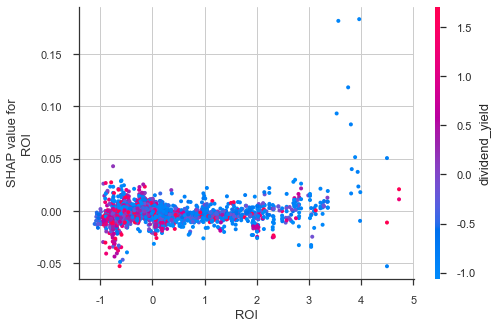

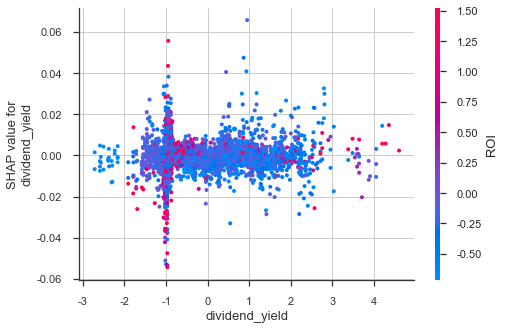

In [44]:
shap.dependence_plot(3, xg_shap_values, X_train,interaction_index="dividend_yield")
shap.dependence_plot(7, xg_shap_values, X_train,interaction_index="ROI")

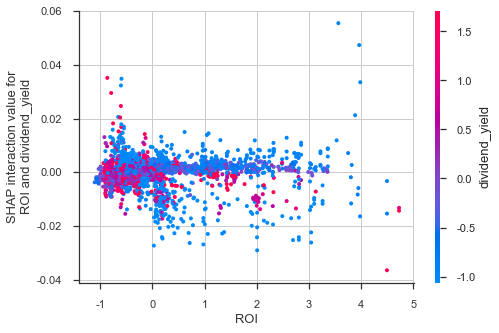

In [43]:
shap.dependence_plot(
    ("ROI", "dividend_yield"),
    xg_shap_interaction, X_train,
    display_features=X_train
)